In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [98]:
import nltk

In [99]:
nltk.download('stopwords') #for downloading stopwords package

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AYUSH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [100]:
#getting the dataset of messages

In [101]:
messages=pd.read_csv('SMSSpamCollection',sep='\t',names=['label','message'])

In [102]:
print(len(messages))

5572


In [103]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [104]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [105]:
messages['length']=messages['message'].apply(len)

In [106]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


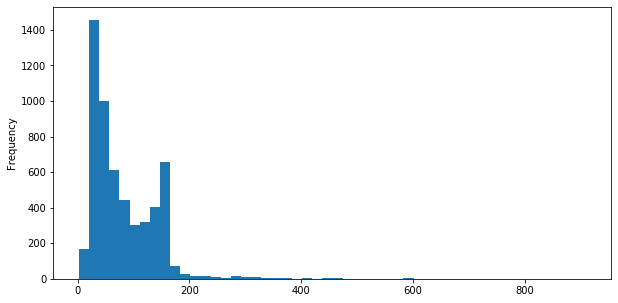

In [20]:
messages['length'].plot.hist(bins=50,figsize=(10,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000065B56C90C8>,
      dtype=object)

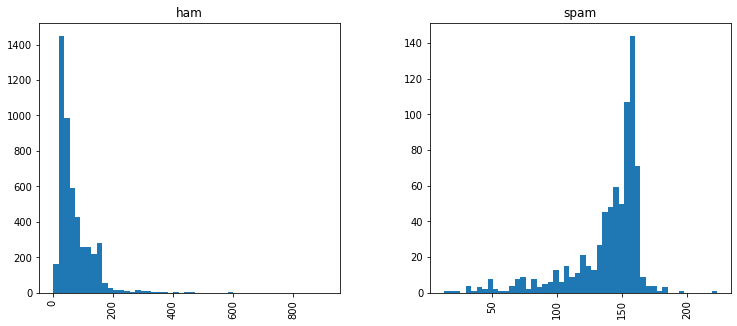

In [23]:
messages.hist(column='length',by='label',bins=50,figsize=(12,5))

In [24]:
#cleaning data

In [11]:
import string

In [12]:
from nltk.corpus import stopwords 

In [13]:
def clean_text(str):
    
    #removing punctuation
    clean_pun=[ch for ch in str if ch not in string.punctuation]
    clean_pun1=''.join(clean_pun)
    
    #removing stopwords
    clean_stop1=list(clean_pun1.split( ))
    clean_str=[x for x in clean_stop1 if x not in stopwords.words('english')]
    
    
    return clean_str

In [50]:
messages['message'].head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [51]:
messages['message'].head().apply(clean_text)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, I, dont, think, goes, usf, lives, around...
Name: message, dtype: object

In [16]:
#vectorizaion

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

In [53]:
bow=CountVectorizer(analyzer=clean_text).fit(messages['message'])

In [54]:
len(bow.vocabulary_)

11617

In [55]:
messages_bow=bow.transform(messages['message'])

In [21]:
messages_bow.shape #shape of sparse matrix

(5572, 11617)

In [22]:
messages_bow.nnz #non zero values in sparse matrix

56024

In [23]:
#finding TFIDF values

In [83]:
from sklearn.feature_extraction.text import TfidfTransformer

In [57]:
tfidf=TfidfTransformer().fit(messages_bow)

In [58]:
messages_tfidf=tfidf.transform(messages_bow)

In [59]:
tfidf.idf_[bow.vocabulary_['word']] #tfidf value for words

6.070340726080123

In [60]:
#model for prediction (MultinomialNB)

In [61]:
from sklearn.naive_bayes import MultinomialNB

In [62]:
model=MultinomialNB()

In [63]:
model.fit(messages_tfidf,messages['label'])

MultinomialNB()

In [64]:
messages_tfidf

<5572x11617 sparse matrix of type '<class 'numpy.float64'>'
	with 56024 stored elements in Compressed Sparse Row format>

In [65]:
pred1=model.predict(messages_tfidf)

In [66]:
pred1

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [34]:
#now training the data and then testing the model

In [107]:
from sklearn.model_selection import train_test_split

In [108]:
msg_train,msg_test,label_train,label_test=train_test_split(messages['message'],messages['label'],test_size=0.4)

In [109]:
#using pipeline for performing repeated operations  

In [110]:
from sklearn.pipeline import Pipeline

In [111]:
pipe=Pipeline([
    ('bow',CountVectorizer(analyzer=clean_text)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [112]:
pipe.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function clean_text at 0x000000DA8C24C280>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [113]:
prediction=pipe.predict(msg_test)

In [114]:
prediction

array(['ham', 'ham', 'ham', ..., 'spam', 'ham', 'ham'], dtype='<U4')

In [125]:
pred=pipe.predict(['Free entry in 2 a wkly comp to win FA Cup final'])

In [126]:
pred

array(['spam'], dtype='<U4')

In [127]:
#saving model

In [4]:
import joblib

In [129]:
joblib.dump(pipe,'model.sav')

['model.sav']

In [14]:
model=joblib.load('model.sav')

In [15]:
model.predict(['Free entry in world cup finals'])

array(['ham'], dtype='<U4')

In [168]:
#evaluate the model

In [169]:
from sklearn.metrics import classification_report,confusion_matrix

In [172]:
print(confusion_matrix(label_test,prediction))
print()
print(classification_report(label_test,prediction))

[[1942    0]
 [  86  201]]

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1942
        spam       1.00      0.70      0.82       287

    accuracy                           0.96      2229
   macro avg       0.98      0.85      0.90      2229
weighted avg       0.96      0.96      0.96      2229

